In [1]:
%matplotlib inline

import os
import sys

PACKAGE_PARENT = '..'
sys.path.append(PACKAGE_PARENT)

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from gaminet import GAMINetRegressor
from gaminet.utils import local_visualize
from gaminet.utils import global_visualize_density
from gaminet.utils import feature_importance_visualize
from gaminet.utils import plot_trajectory
from gaminet.utils import plot_regularization

## Load data

In [2]:
def metric_wrapper(metric, scaler):
    def wrapper(label, pred):
        return metric(label, pred, scaler=scaler)
    return wrapper

def rmse(label, pred, scaler):
    pred = scaler.inverse_transform(pred.reshape([-1, 1]))
    label = scaler.inverse_transform(label.reshape([-1, 1]))
    return np.sqrt(np.mean((pred - label)**2))

def data_generator1(datanum, dist="uniform", random_state=0):
    
    nfeatures = 10
    np.random.seed(random_state)
    x = np.random.uniform(0, 1, [datanum, nfeatures])
    x1, x2, x3, x4, x5, x6 = [x[:, [i]] for i in range(6)]

    def cliff(x1, x2):
        # x1: -20,20
        # x2: -10,5
        x1 = (2 * x1 - 1) * 20
        x2 = (2 * x2 - 1) * 7.5 - 2.5
        term1 = -0.5 * x1 ** 2 / 100
        term2 = -0.5 * (x2 + 0.03 * x1 ** 2 - 3) ** 2
        y = 10 * np.exp(term1 + term2)
        return  y

    y = (8 * (x1 - 0.5) ** 2
        + 0.1 * np.exp(-8 * x2 + 4)
        + 3 * np.sin(2 * np.pi * x3 * x4) + cliff(x5, x6)
        ).reshape([-1,1]) + 1 * np.random.normal(0, 1, [datanum, 1])

    task_type = "Regression"
    meta_info = {"X" + str(i + 1):{'type':'continuous'} for i in range(nfeatures)}
    meta_info.update({'Y':{'type':'target'}})         
    for i, (key, item) in enumerate(meta_info.items()):
        if item['type'] == 'target':
            sy = MinMaxScaler((0, 1))
            y = sy.fit_transform(y)
            meta_info[key]['scaler'] = sy
        else:
            sx = MinMaxScaler((0, 1))
            sx.fit([[0], [1]])
            x[:,[i]] = sx.transform(x[:,[i]])
            meta_info[key]['scaler'] = sx

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)
    return train_x, test_x, train_y, test_y, task_type, meta_info, metric_wrapper(rmse, sy)

random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=10000, random_state=random_state)

## Train GAMI-Net 

In [8]:
model = GAMINetRegressor(interact_num=20,
                hidden_layer_sizes_main_effect=[40] * 5, hidden_layer_sizes_interaction=[40] * 5,
                batch_size=1000, activation_func=torch.nn.ReLU(),
                max_epoch_main_effect=1000, max_epoch_interaction=1000, max_epoch_tuning=100,
                learning_rates=[0.0001, 0.0001, 0.0001], early_stop_thres=[10, 10, 10],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                warm_start=True, verbose=True,
                val_ratio=0.2, device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
                random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############
####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:    1, train loss: 0.01047: 100%|██████████| 7/7 [00:00<00:00, 44.06it/s]                                                  

Epoch:   12, train loss: 0.01040: 100%|██████████| 7/7 [00:00<00:00, 115.38it/s]                                                 


Main Effect Training Stop at Epoch: 12, train loss: 0.01040, val loss: 0.00976
Main Effect Training Stop at Epoch: 12, train loss: 0.01040, val loss: 0.00976
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:    1, train loss: 0.00285: 100%|██████████| 7/7 [00:00<00:00, 19.65it/s]                                                  

Epoch:   32, train loss: 0.00243: 100%|██████████| 7/7 [00:00<00:00, 25.96it/s]                                                  


Epoch:   58, train loss: 0.00231: 100%|██████████| 7/7 [00:00<00:00, 20.68it/s]                                                  

Epoch:   64, train loss: 0.00229: 100%|██████████| 7/7 [00:00<00:00, 24.12it/s]                                                  


Epoch:   96, train loss: 0.00224: 100%|██████████| 7/7 [00:00<00:00, 25.85it/s]                                                  


Epoch:  110, train loss: 0.00223: 100%|██████████| 7/7 [00:00<00:00, 18.51it/s]                                                  

Epoch:  128, train loss: 0.00220: 100%|██████████| 7/7 [00:00<00:00, 26.03it/s]                                                  


Epoch:  135, train loss: 0.00219: 100%|██████████| 7/7 [00:00<00:00, 16.46it/s]                                                  

Epoch:  160, train loss: 0.00216: 100%|██████████| 7/7 [00:00<00:00, 25.55it/s]                                                  


Epoch:  175, train loss: 0.00214: 100%|██████████| 7/7 [00:00<00:00, 22.53it/s]                                                  

Epoch:  192, train loss: 0.00213: 100%|██████████| 7/7 [00:00<00:00, 25.98it/s]                                                  


Epoch:  203, train loss: 0.00212: 100%|██████████| 7/7 [00:00<00:00, 17.86it/s]                                                  

Epoch:  205, train loss: 0.00211: 100%|██████████| 7/7 [00:00<00:00, 21.03it/s]                                                  

Epoch:  224, train loss: 0.00210: 100%|██████████| 7/7 [00:00<00:00, 25.96it/s]                                                  


Epoch:  230, train loss: 0.00209: 100%|██████████| 7/7 [00:00<00:00, 23.31it/s]                                                  

Epoch:  233, train loss: 0.00211: 100%|██████████| 7/7 [00:00<00:00, 23.04it/s]                                                  

Epoch:  242, train loss: 0.00208: 100%|██████████| 7/7 [00:00<00:00, 18.62it/s]                                                  

Epoch:  257, train loss: 0.00207: 100%|██████████| 7/7 [00:00<00:00, 26.09it/s]                                                  


Epoch:  278, train loss: 0.00208: 100%|██████████| 7/7 [00:00<00:00, 18.98it/s]                                                  

Epoch:  280, train loss: 0.00208: 100%|██████████| 7/7 [00:00<00:00, 24.72it/s]                                                  

Epoch:  290, train loss: 0.00207: 100%|██████████| 7/7 [00:00<00:00, 24.77it/s]                                                  


Epoch:  318, train loss: 0.00203: 100%|██████████| 7/7 [00:00<00:00, 24.21it/s]                                                  

Epoch:  319, train loss: 0.00203: 100%|██████████| 7/7 [00:00<00:00, 16.72it/s]                                                  

Epoch:  323, train loss: 0.00203:   0%|          | 0/7 [00:00<?, ?it/s]                                                          


Epoch:  325, train loss: 0.00204: 100%|██████████| 7/7 [00:00<00:00, 20.27it/s]                                                  



Interaction Training Stop at Epoch: 325, train loss: 0.00204, val loss: 0.00203
Interaction Training Stop at Epoch: 325, train loss: 0.00204, val loss: 0.00203
####################Stage 3: Fine Tuning####################
####################Stage 3: Fine Tuning####################


Epoch:   1, train loss: 0.00215: 100%|██████████| 7/7 [00:00<00:00, 22.10it/s]                                                   

Epoch:   2, train loss: 0.00209: 100%|██████████| 7/7 [00:00<00:00, 22.24it/s]                                                   

Epoch:  11, train loss: 0.00203: 100%|██████████| 7/7 [00:00<00:00, 24.19it/s]                                                   

Epoch:  16, train loss: 0.00204: 100%|██████████| 7/7 [00:00<00:00, 20.08it/s]                                                   

Epoch:  22, train loss: 0.00205: 100%|██████████| 7/7 [00:00<00:00, 21.21it/s]                                                   

Epoch:  24, train loss: 0.00202: 100%|██████████| 7/7 [00:00<00:00, 21.47it/s]                                                   

Epoch:  26, train loss: 0.00202: 100%|██████████| 7/7 [00:00<00:00, 25.97it/s]                                                   


Fine Tuning Stop at Epoch: 26, train loss: 0.00202, val loss: 0.00201
Fine Tuning Stop at Epoch: 26, train loss: 0.00202, val loss: 0.00201


In [4]:
val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5),
                          np.round(get_metric(val_y, pred_val),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[1.04522 1.0398  1.04847]


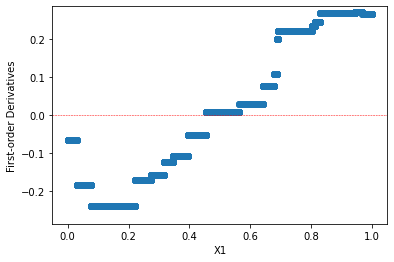

In [5]:
model.partial_derivatives(0)

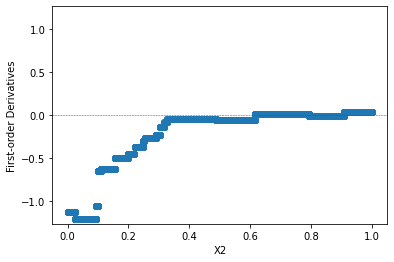

In [6]:
model.partial_derivatives(1)

In [7]:
model.get_clarity_loss(test_x)

0.00017332502466160804

## Visualization

In [6]:
simu_dir = "./results/"
if not os.path.exists(simu_dir):
    os.makedirs(simu_dir)

Training details

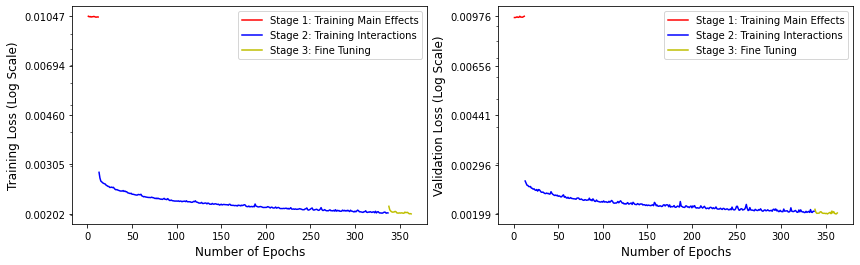

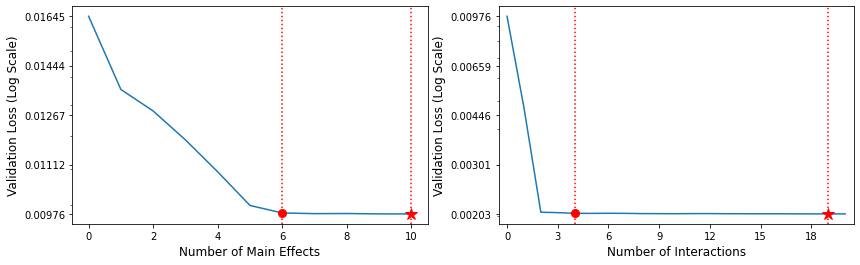

In [9]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

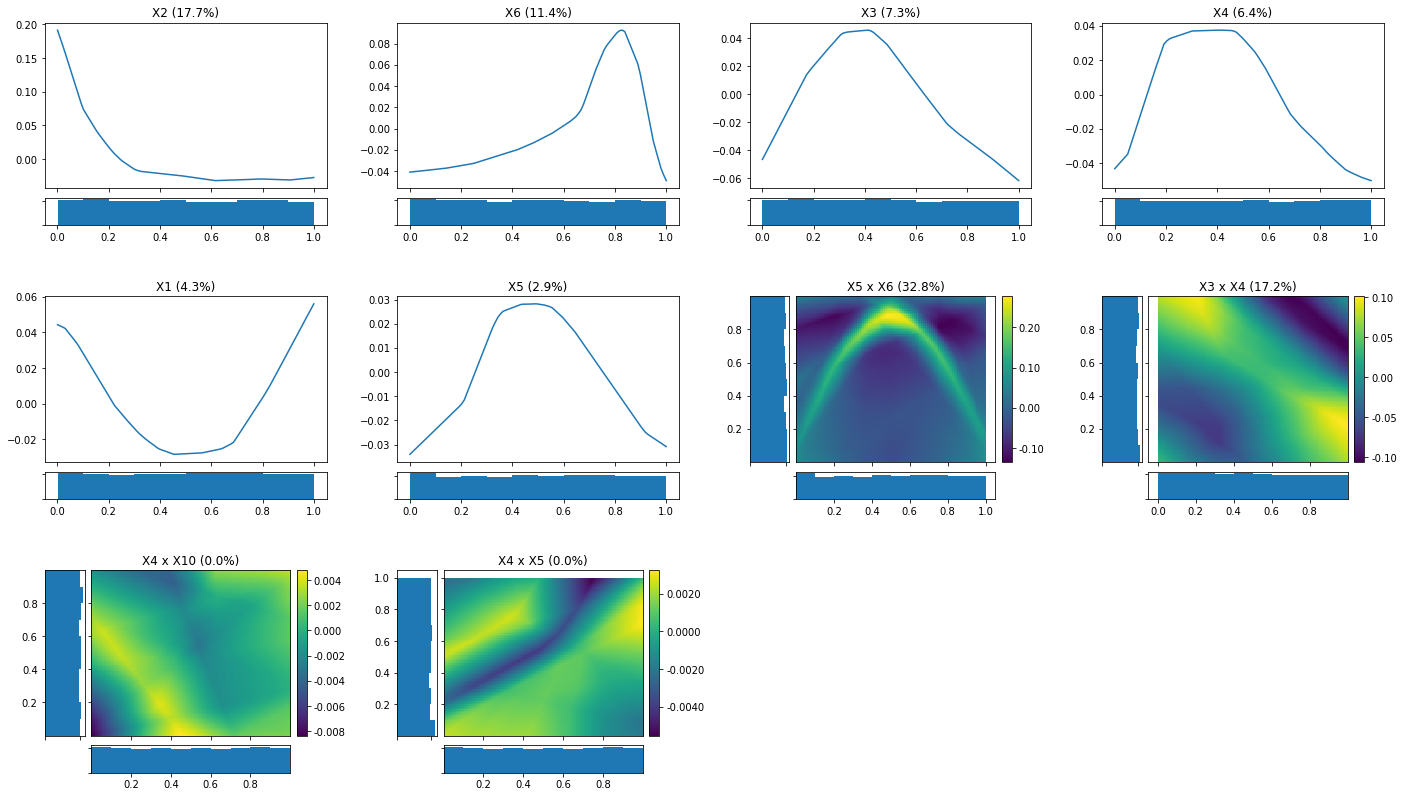

In [10]:
data_dict_global = model.global_explain(save_dict=False)
global_visualize_density(data_dict_global, main_effect_num=6, interaction_num=30, cols_per_row=4, save_png=True, save_eps=True)

Feature Importance

In [ ]:
feature_importance_visualize(data_dict_global, save_png=True, folder=simu_dir, name='s1_feature')

Local Visualization

In [ ]:
data_dict_local = model.local_explain(train_x[:10], train_y[:10], save_dict=False)

In [ ]:
local_visualize(data_dict_local[0], save_png=True, folder=simu_dir, name='s1_local')

## Model save and load 

In [ ]:
model.save(name="simu")
modelnew = GAMINetRegressor()
modelnew.load(name="simu")
modelnew.predict(train_x)

In [3]:
model = GAMINetRegressor(interact_num=20,
                hidden_layer_sizes_main_effect=[40] * 5, hidden_layer_sizes_interaction=[40] * 5,
                batch_size=1000, activation_func=torch.nn.ReLU(),
                max_epoch_main_effect=1000, max_epoch_interaction=1000, max_epoch_tuning=100,
                learning_rates=[0.0001, 0.0001, 0.0001], early_stop_thres=[50, 100, 50],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                max_iteration_per_epoch=np.inf, max_val_size=np.inf,
                warm_start=False, verbose=True, val_ratio=0.2, device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
                random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################


Epoch:    1, train loss: 0.16013:   0%|          | 0/7 [00:00<?, ?it/s]                                                          

####################Stage 1: Main Effect Training####################


Epoch:    1, train loss: 0.15463: 100%|██████████| 7/7 [00:00<00:00, 65.50it/s]                                                  

Epoch:    2, train loss: 0.13899: 100%|██████████| 7/7 [00:00<00:00, 95.84it/s]                                                  

Epoch:    7, train loss: 0.06993: 100%|██████████| 7/7 [00:00<00:00, 107.60it/s]                                                 

Epoch:   13, train loss: 0.02365: 100%|██████████| 7/7 [00:00<00:00, 100.31it/s]                                                 

Epoch:   33, train loss: 0.01824: 100%|██████████| 7/7 [00:00<00:00, 114.46it/s]                                                 


Epoch:   59, train loss: 0.01725: 100%|██████████| 7/7 [00:00<00:00, 100.30it/s]                                                 

Epoch:   65, train loss: 0.01708: 100%|██████████| 7/7 [00:00<00:00, 116.78it/s]                                                 


Epoch:   99, train loss: 0.01340: 100%|██████████| 7/7 [00:00<00:00, 103.72it/s]                                                 


Epoch:  127, train loss: 0.01238: 100%|██████████| 7/7 [00:00<00:00, 120.22it/s]                                                 


Epoch:  154, train loss: 0.01188: 100%|██████████| 7/7 [00:00<00:00, 110.13it/s]                                                 


Epoch:  182, train loss: 0.01148: 100%|██████████| 7/7 [00:00<00:00, 112.38it/s]                                                 


Epoch:  231, train loss: 0.01108: 100%|██████████| 7/7 [00:00<00:00, 108.01it/s]                                                 


Epoch:  259, train loss: 0.01094: 100%|██████████| 7/7 [00:00<00:00, 115.49it/s]                                                 


Epoch:  287, train loss: 0.01075: 100%|██████████| 7/7 [00:00<00:00, 112.86it/s]                                                 


Epoch:  315, train loss: 0.01060: 100%|██████████| 7/7 [00:00<00:00, 113.57it/s]                                                 


Epoch:  345, train loss: 0.01048: 100%|██████████| 7/7 [00:00<00:00, 120.04it/s]                                                 


Epoch:  384, train loss: 0.01043: 100%|██████████| 7/7 [00:00<00:00, 109.25it/s]                                                 


Epoch:  403, train loss: 0.01041: 100%|██████████| 7/7 [00:00<00:00, 114.63it/s]                                                 


Main Effect Training Stop at Epoch: 403, train loss: 0.01041, val loss: 0.00973
####################Stage 2: Interaction Training####################


Epoch:  403, train loss: 0.01041: 100%|██████████| 7/7 [00:00<00:00, 114.63it/s]                                                 


Main Effect Training Stop at Epoch: 403, train loss: 0.01041, val loss: 0.00973
####################Stage 2: Interaction Training####################


Epoch:   34, train loss: 0.01002: 100%|██████████| 7/7 [00:00<00:00, 25.53it/s]                                                  


Epoch:   65, train loss: 0.00713: 100%|██████████| 7/7 [00:00<00:00, 26.12it/s]                                                  


Epoch:   78, train loss: 0.00620: 100%|██████████| 7/7 [00:00<00:00, 24.64it/s]                                                  

Epoch:   93, train loss: 0.00575: 100%|██████████| 7/7 [00:00<00:00, 24.10it/s]                                                  

Epoch:   94, train loss: 0.00572: 100%|██████████| 7/7 [00:00<00:00, 17.62it/s]                                                  

  0%|          | 0/7 [00:00<?, ?it/s]                                                                                            


Epoch:  116, train loss: 0.00544: 100%|██████████| 7/7 [00:00<00:00, 23.95it/s]                                                  

Epoch:  122, train loss: 0.00537: 100%|██████████| 7/7 [00:00<00:00, 20.81it/s]                                                  

Epoch:  132, train loss: 0.00530: 100%|██████████| 7/7 [00:00<00:00, 25.86it/s]                                                  


Epoch:  137, train loss: 0.00524: 100%|██████████| 7/7 [00:00<00:00, 22.75it/s]                                                  

Epoch:  143, train loss: 0.00520: 100%|██████████| 7/7 [00:00<00:00, 24.51it/s]                                                  

Epoch:  146, train loss: 0.00517: 100%|██████████| 7/7 [00:00<00:00, 23.34it/s]                                                  

Epoch:  157, train loss: 0.00513: 100%|██████████| 7/7 [00:00<00:00, 18.19it/s]                                                  

Epoch:  161, train loss: 0.00509: 100%|██████████| 7/7 [00:00<00:00, 18.23it/s]                                                  

Epoch:  165, train loss: 0.00506: 100%|██████████| 7/7 [00:00<00:00, 25.55it/s]                                                  


Epoch:  170, train loss: 0.00506: 100%|██████████| 7/7 [00:00<00:00, 23.91it/s]                                                  

Epoch:  174, train loss: 0.00504: 100%|██████████| 7/7 [00:00<00:00, 21.05it/s]                                                  

Epoch:  193, train loss: 0.00494: 100%|██████████| 7/7 [00:00<00:00, 24.74it/s]                                                  

Epoch:  194, train loss: 0.00494: 100%|██████████| 7/7 [00:00<00:00, 17.58it/s]                                                  

Epoch:  198, train loss: 0.00495: 100%|██████████| 7/7 [00:00<00:00, 26.05it/s]                                                  


Epoch:  230, train loss: 0.00480: 100%|██████████| 7/7 [00:00<00:00, 25.52it/s]                                                  


Epoch:  240, train loss: 0.00479: 100%|██████████| 7/7 [00:00<00:00, 23.34it/s]                                                  

Epoch:  244, train loss: 0.00475: 100%|██████████| 7/7 [00:00<00:00, 21.23it/s]                                                  

Epoch:  248, train loss: 0.00474: 100%|██████████| 7/7 [00:00<00:00, 24.73it/s]                                                  

Epoch:  256, train loss: 0.00472: 100%|██████████| 7/7 [00:00<00:00, 23.99it/s]                                                  

Epoch:  258, train loss: 0.00471: 100%|██████████| 7/7 [00:00<00:00, 20.01it/s]                                                  

Epoch:  263, train loss: 0.00470: 100%|██████████| 7/7 [00:00<00:00, 20.32it/s]                                                  

Epoch:  264, train loss: 0.00468: 100%|██████████| 7/7 [00:00<00:00, 25.84it/s]                                                  


Epoch:  286, train loss: 0.00457: 100%|██████████| 7/7 [00:00<00:00, 24.32it/s]                                                  

Epoch:  295, train loss: 0.00451: 100%|██████████| 7/7 [00:00<00:00, 24.65it/s]                                                  

Epoch:  296, train loss: 0.00451: 100%|██████████| 7/7 [00:00<00:00, 25.47it/s]                                                  


Epoch:  305, train loss: 0.00446: 100%|██████████| 7/7 [00:00<00:00, 24.28it/s]                                                  

Epoch:  321, train loss: 0.00436: 100%|██████████| 7/7 [00:00<00:00, 22.49it/s]                                                  

Epoch:  329, train loss: 0.00429: 100%|██████████| 7/7 [00:00<00:00, 26.17it/s]                                                  


Epoch:  360, train loss: 0.00405: 100%|██████████| 7/7 [00:00<00:00, 25.67it/s]                                                  


Epoch:  392, train loss: 0.00386: 100%|██████████| 7/7 [00:00<00:00, 19.56it/s]                                                  


  0%|          | 0/7 [00:00<?, ?it/s]                                                                                            


Epoch:  433, train loss: 0.00358: 100%|██████████| 7/7 [00:00<00:00, 20.42it/s]                                                  

Epoch:  437, train loss: 0.00356: 100%|██████████| 7/7 [00:00<00:00, 18.89it/s]                                                  

Epoch:  444, train loss: 0.00348: 100%|██████████| 7/7 [00:00<00:00, 20.44it/s]                                                  

Epoch:  456, train loss: 0.00342: 100%|██████████| 7/7 [00:00<00:00, 24.90it/s]                                                  


Epoch:  458, train loss: 0.00338: 100%|██████████| 7/7 [00:00<00:00, 23.30it/s]                                                  

Epoch:  480, train loss: 0.00327: 100%|██████████| 7/7 [00:00<00:00, 22.99it/s]                                                  

Epoch:  489, train loss: 0.00322: 100%|██████████| 7/7 [00:00<00:00, 21.51it/s]                                                  


Epoch:  496, train loss: 0.00315: 100%|██████████| 7/7 [00:00<00:00, 21.92it/s]                                                  

Epoch:  521, train loss: 0.00301: 100%|██████████| 7/7 [00:00<00:00, 25.76it/s]                                                  


Epoch:  527, train loss: 0.00295: 100%|██████████| 7/7 [00:00<00:00, 22.92it/s]                                                  

Epoch:  536, train loss: 0.00292: 100%|██████████| 7/7 [00:00<00:00, 19.94it/s]                                                  

Epoch:  542, train loss: 0.00289: 100%|██████████| 7/7 [00:00<00:00, 20.37it/s]                                                  

Epoch:  554, train loss: 0.00289: 100%|██████████| 7/7 [00:00<00:00, 25.62it/s]                                                  


Epoch:  563, train loss: 0.00279: 100%|██████████| 7/7 [00:00<00:00, 18.68it/s]                                                  

Epoch:  564, train loss: 0.00279: 100%|██████████| 7/7 [00:00<00:00, 19.28it/s]                                                  

Epoch:  577, train loss: 0.00276: 100%|██████████| 7/7 [00:00<00:00, 24.41it/s]                                                  

Epoch:  587, train loss: 0.00272: 100%|██████████| 7/7 [00:00<00:00, 25.89it/s]                                                  


Epoch:  596, train loss: 0.00270: 100%|██████████| 7/7 [00:00<00:00, 23.05it/s]                                                  

Epoch:  617, train loss: 0.00262: 100%|██████████| 7/7 [00:00<00:00, 24.27it/s]                                                  

Epoch:  619, train loss: 0.00263: 100%|██████████| 7/7 [00:00<00:00, 19.54it/s]                                                  


Epoch:  642, train loss: 0.00257: 100%|██████████| 7/7 [00:00<00:00, 24.47it/s]                                                  

Epoch:  648, train loss: 0.00253: 100%|██████████| 7/7 [00:00<00:00, 22.22it/s]                                                  

Epoch:  652, train loss: 0.00255: 100%|██████████| 7/7 [00:00<00:00, 25.75it/s]                                                  


Epoch:  680, train loss: 0.00251: 100%|██████████| 7/7 [00:00<00:00, 20.48it/s]                                                  

Epoch:  684, train loss: 0.00248: 100%|██████████| 7/7 [00:00<00:00, 23.94it/s]                                                  


Epoch:  693, train loss: 0.00245: 100%|██████████| 7/7 [00:00<00:00, 23.27it/s]                                                  

Epoch:  711, train loss: 0.00247: 100%|██████████| 7/7 [00:00<00:00, 17.23it/s]                                                  

Epoch:  716, train loss: 0.00245: 100%|██████████| 7/7 [00:00<00:00, 24.70it/s]                                                  


Epoch:  748, train loss: 0.00244: 100%|██████████| 7/7 [00:00<00:00, 26.47it/s]                                                  


Epoch:  779, train loss: 0.00237: 100%|██████████| 7/7 [00:00<00:00, 25.44it/s]                                                  


Epoch:  784, train loss: 0.00236: 100%|██████████| 7/7 [00:00<00:00, 22.76it/s]                                                  

Epoch:  795, train loss: 0.00231: 100%|██████████| 7/7 [00:00<00:00, 23.28it/s]                                                  

Epoch:  810, train loss: 0.00232: 100%|██████████| 7/7 [00:00<00:00, 19.01it/s]                                                  

Epoch:  812, train loss: 0.00238: 100%|██████████| 7/7 [00:00<00:00, 25.59it/s]                                                  


Epoch:  834, train loss: 0.00227: 100%|██████████| 7/7 [00:00<00:00, 21.57it/s]                                                  

Epoch:  844, train loss: 0.00226: 100%|██████████| 7/7 [00:00<00:00, 25.01it/s]                                                  


Epoch:  871, train loss: 0.00220: 100%|██████████| 7/7 [00:00<00:00, 23.05it/s]                                                  

Epoch:  876, train loss: 0.00219: 100%|██████████| 7/7 [00:00<00:00, 25.95it/s]                                                  


Epoch:  886, train loss: 0.00216: 100%|██████████| 7/7 [00:00<00:00, 20.07it/s]                                                  

Epoch:  887, train loss: 0.00216: 100%|██████████| 7/7 [00:00<00:00, 18.31it/s]                                                  

Epoch:  888, train loss: 0.00214: 100%|██████████| 7/7 [00:00<00:00, 21.34it/s]                                                  

Epoch:  909, train loss: 0.00215: 100%|██████████| 7/7 [00:00<00:00, 25.34it/s]                                                  


Epoch:  914, train loss: 0.00211: 100%|██████████| 7/7 [00:00<00:00, 20.42it/s]                                                  

Epoch:  931, train loss: 0.00215: 100%|██████████| 7/7 [00:00<00:00, 19.87it/s]                                                  

Epoch:  942, train loss: 0.00207: 100%|██████████| 7/7 [00:00<00:00, 26.43it/s]                                                  


Epoch:  948, train loss: 0.00208: 100%|██████████| 7/7 [00:00<00:00, 23.07it/s]                                                  

Epoch:  955, train loss: 0.00207: 100%|██████████| 7/7 [00:00<00:00, 20.58it/s]                                                  

Epoch:  959, train loss: 0.00207: 100%|██████████| 7/7 [00:00<00:00, 24.49it/s]                                                  

Epoch:  975, train loss: 0.00205: 100%|██████████| 7/7 [00:00<00:00, 25.13it/s]                                                  


Epoch:  988, train loss: 0.00204: 100%|██████████| 7/7 [00:00<00:00, 19.58it/s]                                                  

Epoch: 1000, train loss: 0.00204: 100%|██████████| 7/7 [00:00<00:00, 25.99it/s]                                                  


####################Stage 3: Fine Tuning####################
####################Stage 3: Fine Tuning####################


Epoch:   1, train loss: 0.00216: 100%|██████████| 7/7 [00:00<00:00, 22.53it/s]                                                   

Epoch:   4, train loss: 0.00208: 100%|██████████| 7/7 [00:00<00:00, 20.57it/s]                                                   

Epoch:   5, train loss: 0.00208: 100%|██████████| 7/7 [00:00<00:00, 22.89it/s]                                                   

Epoch:   7, train loss: 0.00207: 100%|██████████| 7/7 [00:00<00:00, 20.94it/s]                                                   

Epoch:  19, train loss: 0.00202: 100%|██████████| 7/7 [00:00<00:00, 16.30it/s]                                                   

Epoch:  33, train loss: 0.00200: 100%|██████████| 7/7 [00:00<00:00, 20.87it/s]                                                   

Epoch:  34, train loss: 0.00201: 100%|██████████| 7/7 [00:00<00:00, 18.67it/s]                                                   

Epoch:  35, train loss: 0.00200: 100%|██████████| 7/7 [00:00<00:00, 22.43it/s]     

Epoch:  37, train loss: 0.00199: 100%|██████████| 7/7 [00:00<00:00, 24.63it/s]                                                   

Epoch:  50, train loss: 0.00199: 100%|██████████| 7/7 [00:00<00:00, 24.70it/s]                                                   

Epoch:  53, train loss: 0.00200: 100%|██████████| 7/7 [00:00<00:00, 20.71it/s]                                                   

Epoch:  57, train loss: 0.00200: 100%|██████████| 7/7 [00:00<00:00, 20.78it/s]                                                   

Epoch:  58, train loss: 0.00198: 100%|██████████| 7/7 [00:00<00:00, 20.18it/s]                                                   

Epoch:  63, train loss: 0.00199: 100%|██████████| 7/7 [00:00<00:00, 18.50it/s]                                                   

Epoch:  65, train loss: 0.00201: 100%|██████████| 7/7 [00:00<00:00, 24.38it/s]                                                   

Epoch:  70, train loss: 0.00199: 100%|██████████| 7/7 [00:00<00:00, 24.82it/s]     

Epoch:  78, train loss: 0.00201: 100%|██████████| 7/7 [00:00<00:00, 24.51it/s]                                                   

Epoch:  79, train loss: 0.00202: 100%|██████████| 7/7 [00:00<00:00, 21.12it/s]                                                   

Epoch:  91, train loss: 0.00204: 100%|██████████| 7/7 [00:00<00:00, 22.89it/s]                                                   

Epoch:  97, train loss: 0.00200: 100%|██████████| 7/7 [00:00<00:00, 22.82it/s]                                                   

Epoch: 100, train loss: 0.00196: 100%|██████████| 7/7 [00:00<00:00, 25.19it/s]                                                   


In [4]:
val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5),
                          np.round(get_metric(val_y, pred_val),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[1.03447 1.03466 1.04684]
[1.03447 1.03466 1.04684]


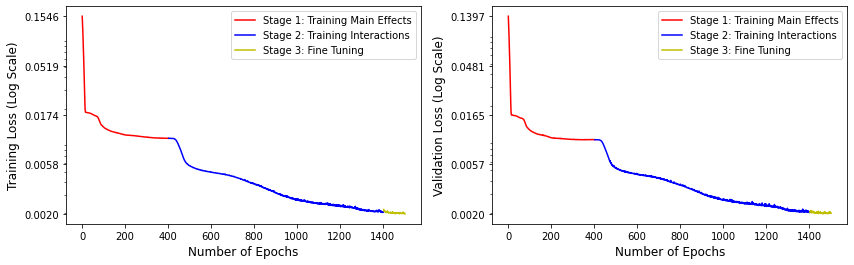

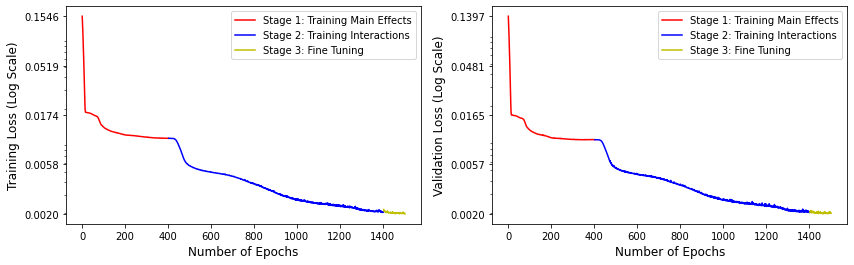

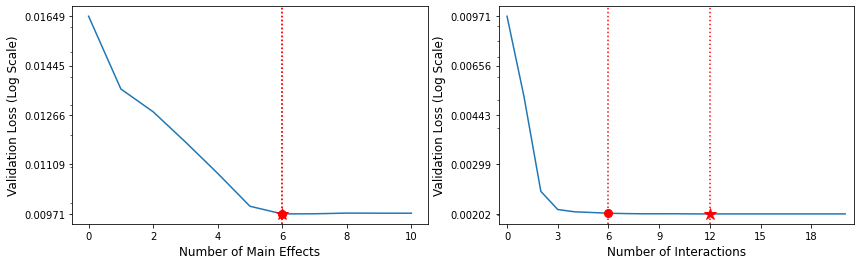

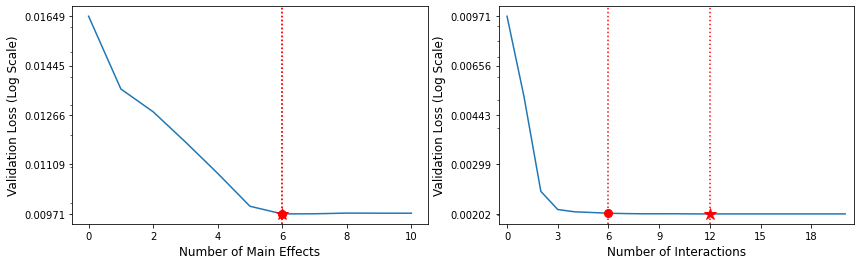

In [7]:
data_dict_logs = model.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=True, save_eps=False)
plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=True, save_eps=False)

In [18]:
random_state = 0
train_x, test_x, train_y, test_y, task_type, meta_info, get_metric = data_generator1(datanum=1000000, random_state=random_state)

In [19]:
model = GAMINetRegressor(interact_num=20,
                hidden_layer_sizes_main_effect=[40] * 5, hidden_layer_sizes_interaction=[40] * 5,
                batch_size=1000, activation_func=torch.nn.ReLU(),
                max_epoch_main_effect=1000, max_epoch_interaction=1000, max_epoch_tuning=100,
                learning_rates=[0.0001, 0.0001, 0.0001], early_stop_thres=[0, 0, 0],
                heredity=True, loss_threshold=0.01, reg_clarity=1,
                warm_start=True, verbose=True, val_ratio=0.2, device=torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
                random_state=random_state)
model.fit(train_x, train_y)

####################Stage 1: Main Effect Training####################
###############Run Warm Initialization for Main Effect###############


Epoch:   5, train loss: 0.00763: 100%|██████████| 100/100 [00:00<00:00, 102.36it/s]                                              


Main Effect Training Stop at Epoch: 5, train loss: 0.00763, val loss: 0.00772
####################Stage 2: Interaction Training####################
###############Run Warm Initialization for Interaction###############


Epoch:  12, train loss: 0.00163: 100%|██████████| 100/100 [00:04<00:00, 23.19it/s]                                               


Interaction Training Stop at Epoch: 12, train loss: 0.00163, val loss: 0.00168
####################Stage 3: Fine Tuning####################


Epoch:  2, train loss: 0.00160: 100%|██████████| 100/100 [00:04<00:00, 20.58it/s]                                                


Fine Tuning Stop at Epoch: 2, train loss: 0.00160, val loss: 0.00162


In [20]:
val_x = train_x[model.val_idx, :]
val_y = train_y[model.val_idx, :]
tr_x = train_x[model.tr_idx, :]
tr_y = train_y[model.tr_idx, :]
pred_train = model.predict(tr_x)
pred_val = model.predict(val_x)
pred_test = model.predict(test_x)
gaminet_stat = np.hstack([np.round(get_metric(tr_y, pred_train),5),
                          np.round(get_metric(val_y, pred_val),5),
                          np.round(get_metric(test_y, pred_test),5)])
print(gaminet_stat)

[1.07352 1.07922 1.0704 ]
